# Contexto Analítico

El [autor](https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset) del dataset seleccionado logró crear un detector de humo con la ayuda de dispositivos [IoT](https://es.wikipedia.org/wiki/Internet_de_las_cosas) y un modelo de IA. Para ello, se realizaron numerosas pruebas en distintas condiciones externas y con diferentes fuentes de fuego, de esa manera se garantiza una muestra heterogénea de datos para el entrenamiento de la IA. 

Las variables del dataset son:
- UTC: Tiempo Universal coordinado (tiempo en el que se llevó a cabo el experimento). 
- Temperature[C]: Temperatura de los alrededores, en Celsius.
- Humidity[%]: Humedad de ambiente.
- TVOC[ppb]: Compuestos organicos volatiles totales, en ppb. 
- eCO2[ppm]: Concentración de CO<sub>2</sub>, en ppm.
- Raw H2: Hidrógeno crudo en alrededores.
- Raw Ethanol: Etanol crudo en el ambiente.
- Pressure[hPa]: Presión atmosférica, en hPa.
- PM1.0: Partículas de diámetro menor a 1.0 micrómetros.
- PM2.5: Partículas de diámetro menor a 2.5 micrómetros.
- NC0.5: Concentración de particulas de diámetro menor a 0.5 micrómetros.
- NC1.0: Concentración de particulas de diámetro menor a 1.0 micrómetros.
- NC2.5: Concentración de particulas de diámetro menor a 2.5 micrómetros.
- CNT: Contador de prueba.
- Fire Alarm: 1 positivo,  0 no positivo. 

Para recolección de datos de entrenamiento se muestrearon muchos entornos y distintas fuentes de fuego que incluyen:

- Interiores normales
- Normal al aire libre
- Fuego de leña interior, zona de formación de bomberos
- Chimenea de gas interior, área de entrenamiento de bomberos
- Parrilla exterior de leña, carbón y gas
- Alta humedad exterior

El conjunto de datos tiene casi 60.000 lecturas. Se ha testeado en condiciones extremas de temperatura para verificar el correcto funcionamiento del sensor y evitar falsas alarmas.

[Fuente](https://www.hackster.io/stefanblattmann/real-time-smoke-detection-with-ai-based-sensor-fusion-1086e6).

# Desarrollo

## Análisis exploratorio de datos (Exploratory Data Analysis)

Se aplicará análisis exploratorio de datos, de ahora en mas EDA, para hacer una exploración inicial de los datos, identificar patrones y chequear las hipótesis planteadas. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,recall_score, f1_score, confusion_matrix

In [2]:
df_smoke=pd.read_csv('/workspaces/codespaces-blank/Proyecto_DS/datasets/raw/smoke_detection_iot.csv')

df_smoke = df_smoke.drop('Unnamed: 0', axis='columns')
#df_smoke.index = df_smoke['CNT']
df_smoke = df_smoke.drop('CNT', axis='columns')

from datetime import datetime

df_smoke['UTC'] = pd.to_datetime(df_smoke['UTC'], unit='s')
df_smoke.head()

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
0,2022-06-09 00:08:51,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0
1,2022-06-09 00:08:52,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,0
2,2022-06-09 00:08:53,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,0
3,2022-06-09 00:08:54,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,0
4,2022-06-09 00:08:55,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,0


In [3]:
df_smoke.shape

(62630, 14)

## Ingeniería de factores

In [4]:
df_smoke.isnull().sum()

UTC               0
Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
Fire Alarm        0
dtype: int64

In [5]:
df_smoke['Day']=df_smoke['UTC'].dt.day
df_smoke['Month']=df_smoke['UTC'].dt.month
df_smoke['Year']=df_smoke['UTC'].dt.year 
df_smoke= df_smoke.drop(columns=['UTC'])
df_smoke.head()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm,Day,Month,Year
0,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,9,6,2022
1,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,0,9,6,2022
2,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,0,9,6,2022
3,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,0,9,6,2022
4,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,0,9,6,2022


En mi base de datos todas las variables son numéricas, no puedo aplicar One Hot Encoding.

## Distribución de los datos

Queremos ver qué tipo de distribución siguen los datos, ya que algunos métodos solo son válidos cuando los datos siguen una distribución normal.

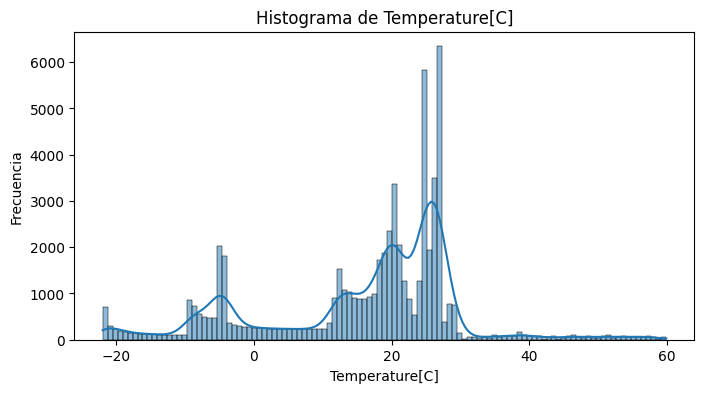

Temperature[C] no sigue una distribución normal


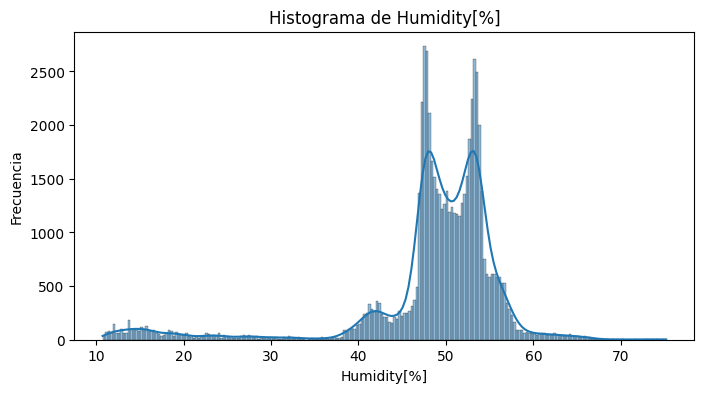

Humidity[%] no sigue una distribución normal


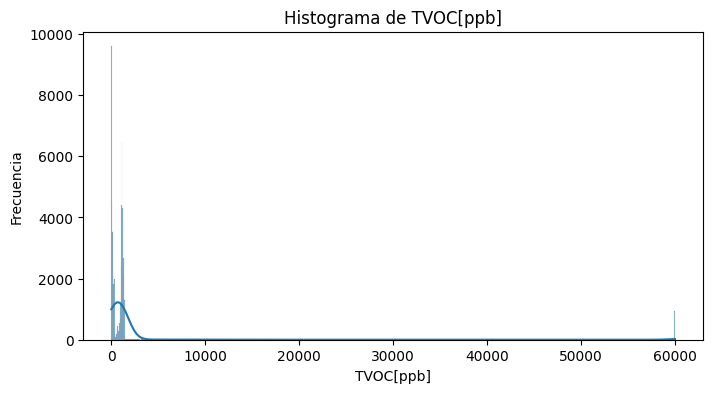

TVOC[ppb] no sigue una distribución normal


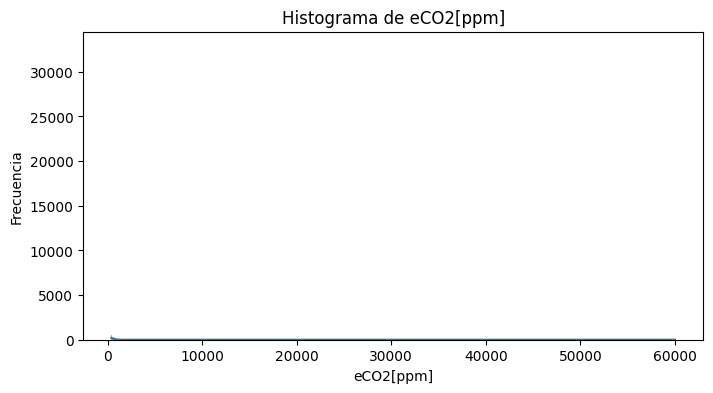

eCO2[ppm] no sigue una distribución normal


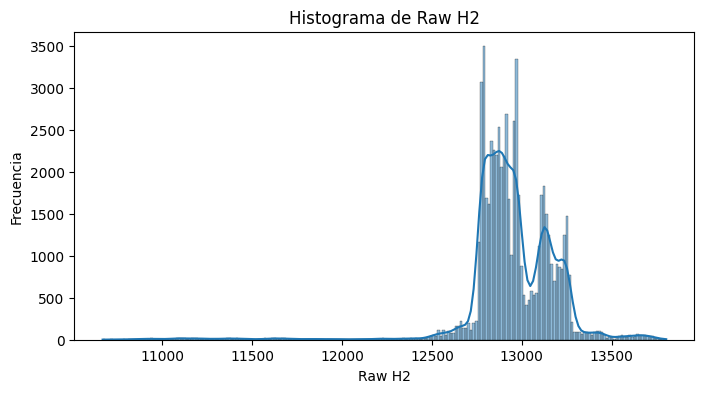

Raw H2 no sigue una distribución normal


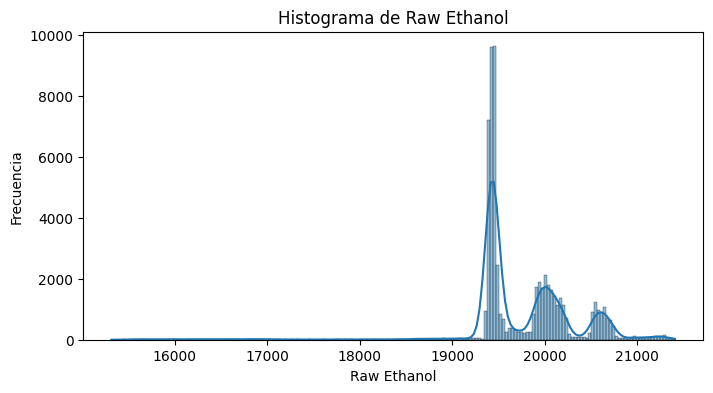

Raw Ethanol no sigue una distribución normal


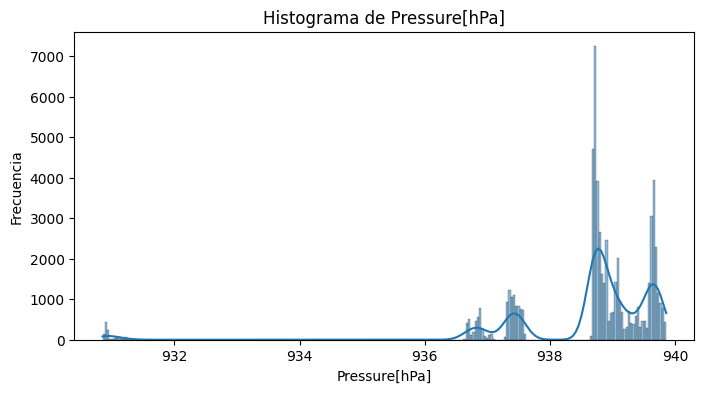

Pressure[hPa] no sigue una distribución normal


In [6]:
columnas = df_smoke.columns

#Aclaración, saco estas variables porque no me para de crushear el Kernel si no.
for columna in columnas:
    if columna not in ['PM1.0', 'PM2.5','NC0.5','NC1.0', 'NC2.5', 'Fire Alarm','Day', 'Year', 'Month']:   
        plt.figure(figsize=(8, 4))
        
        
        sns.histplot(df_smoke[columna], kde=True)
        plt.xlabel(columna)
        plt.ylabel('Frecuencia')
        plt.title('Histograma de {}'.format(columna))
        plt.show()
        
        
        _, p_value = stats.normaltest(df_smoke[columna])
        if p_value < 0.05:
            print('{} no sigue una distribución normal'.format(columna))
        else:
            print('{} sigue una distribución normal'.format(columna))

Ninguno de los parámetros analizados sigue una distribución normal.

## Outliers

Como estamos trabajando con un detector de humos, el tratamiento de outliers puede ser tricky, ya que la presencia de éstos puede deberse a la existencia de un incendio. Lo primero que haremos para esto, es ver si existe una relación entre la presencia de outliers y que la alarma suene o no. Para ello vamos a identificar los outliers con diferentes técnicas.

### Método IQR

In [7]:
X = df_smoke#.drop("Fire Alarm", axis=1) 
#y = df_smoke['Fire Alarm']               
#df_smoke.head()

In [8]:
from scipy import stats
q1 = X.quantile(0.25)
q3 = X.quantile(0.75)
iqr = q3 - q1
X_r= X.copy()

#X_r=X_r.drop(columns=['Day','Month', 'Year'])
X_r.head()

X_r['outlier_iqr'] = X_r.apply(lambda row: 1 if any(np.abs(row - q3) > 1.5*iqr) else 0, axis=1)
X_r['outlier_iqr'].value_counts()


1    40217
0    22413
Name: outlier_iqr, dtype: int64

Según este método, hay más outliers que datos que sirven.

In [9]:
med = X.median()
X_r['outlier_tukey']=X_r.drop(columns='outlier_iqr').apply(lambda row: 1 if any(np.abs(row - med) > 1.5*iqr) \
                                                            else 0, axis=1)
X_r['outlier_tukey'].value_counts()

1    38873
0    23757
Name: outlier_tukey, dtype: int64

Lo mismo sucede con el Tukey.

In [10]:
x_r_filtrado=X_r[~((X_r['outlier_iqr']==1) & (X_r['outlier_tukey']==1))]
indexes=x_r_filtrado.index

Partir con una base de datos de 62000 filas y quedarse con menos de la mitad no parece adecuado, veamos si los outliers se relacionan con el disparo de la alarma.

In [11]:
outliers = X_r[X_r['outlier_iqr'] == 1]
non_outliers = X_r[X_r['outlier_iqr'] == 0]

alarms_outliers = outliers['Fire Alarm'].sum()
alarms_non_outliers = non_outliers['Fire Alarm'].sum()

In [1]:
plt.figure()
sns.histplot(outliers['Fire Alarm'], label='Outliers')
sns.histplot(non_outliers['Fire Alarm'], label='No Outliers')
plt.xlabel('Cantidad de veces que sonó la alarma')
plt.ylabel('Frecuencia')
plt.title('Distribución frecuencias')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

Como los datos no siguen distribución normal no puedo aplicar t-student, tengo que aplicar otro llamado Mann-Whitney.

In [13]:
u_statistic, p_value = stats.mannwhitneyu(outliers['Fire Alarm'], non_outliers['Fire Alarm'])
print(u_statistic, p_value)

274698476.0 0.0


Diferencia significativa entre ambos grupos (como puede verse del gráfico). Al parecer la mayor cantidad de los datos que NO hacen sonar la alarma corresponden a outliers, mientras que pocos de los datos no-outlier no hacen sonar la alarma. Los valores que hacen sonar la alarma están bastante equitativamente distribuidos entre outliers y no outliers.

No estoy segura en estos casos qué se deben hacer con los outliers. Si la distribución hubiera dado al revés (outliers hacen sonar la alarma), los hubiera dejado para entrenar el modelo. En este caso voy a usar el dataframe con y sin outliers para comparar los modelos de entrenamientos y ver cuál da mejores resultados.

In [14]:
stats_by_alarm = df_smoke.groupby('Fire Alarm').describe()

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

print(stats_by_alarm)


           Temperature[C]                                                            Humidity[%]                                                          TVOC[ppb]                                                                 eCO2[ppm]                                                                 Raw H2                                                                        Raw Ethanol                                                                        Pressure[hPa]                                                                       PM1.0                                                               PM2.5                                                               NC0.5                                                                   NC1.0                                                                    NC2.5                                                                      Day                                                   Month                                      

Vemos que hay diferencias significativas entre las medias de cada parámetro cuando la alarma sonó o no sonó. Vemos que la desviación estandar en casi todos los parámetros es mayor cuando la alarma no suena, excepto para el caso de presión atmosférica.
Veamos si estas diferencias entre las medias son signficativas, para eso se aplicará el test de Mann-Whitney ya que los datos no siguen una distribución normal.

In [15]:
parametros = df_smoke.columns

#Aclaración, saco estas variables porque no me para de crushear el Kernel si no.
for parametro in parametros:
    if parametro not in ['Fire Alarm','Day', 'Year', 'Month']:  
        alarma_sono = df_smoke[df_smoke['Fire Alarm'] == 1][parametro]
        alarma_no_sono = df_smoke[df_smoke['Fire Alarm'] == 0][parametro]

        u_statistic, p_value = stats.mannwhitneyu(alarma_sono, alarma_no_sono)

        print("Parámetro:", parametro)
        print("Estadística U:", u_statistic)
        print("Valor p:", p_value)
        print()


Parámetro: Temperature[C]
Estadística U: 330996521.0
Valor p: 8.63865841562793e-250

Parámetro: Humidity[%]
Estadística U: 608569221.0
Valor p: 0.0

Parámetro: TVOC[ppb]
Estadística U: 616635483.5
Valor p: 0.0

Parámetro: eCO2[ppm]
Estadística U: 478762931.0
Valor p: 0.0

Parámetro: Raw H2
Estadística U: 466025352.5
Valor p: 2.888537286967378e-229

Parámetro: Raw Ethanol
Estadística U: 151813855.5
Valor p: 0.0

Parámetro: Pressure[hPa]
Estadística U: 523470434.0
Valor p: 0.0

Parámetro: PM1.0
Estadística U: 524866441.5
Valor p: 0.0

Parámetro: PM2.5
Estadística U: 523163242.0
Valor p: 0.0

Parámetro: NC0.5
Estadística U: 525166531.5
Valor p: 0.0

Parámetro: NC1.0
Estadística U: 522901871.5
Valor p: 0.0

Parámetro: NC2.5
Estadística U: 502664351.5
Valor p: 0.0



Los resultados de la prueba Mann-Whitney sugieren que hay una diferencia significativa en las mediciones de cada parámetro entre los casos donde la alarma sonó y no sonó. La diferencia es lo suficientemente grande como para ser estadísticamente significativa.
Los resultados sugieren que estos parámetros podrían ser relevantes para distinguir entre las dos situaciones y podrían ser útiles en la detección de alarmas.

#### Aclaración
Podría hacer una transformación de mis datos para normalizarlos, por ejemplo usando el método Yeo-Johnson, y luego usar modelos de machine learning que requieran una distribución normal. Yo no voy a hacer esto (quizás sí lo haga en una próxima instancia) pero sí voy a asegurarme de trabajar con modelos de ML que no requieran ni distribución normal ni linealidad.

Como de una entrega previa ya se que no hay valores faltantes ni nulos en el dataset seleccionado, voy a saltear ese análisis.

In [16]:
X = df_smoke.drop("Fire Alarm", axis=1) 
y = df_smoke['Fire Alarm']               # target feature
df_smoke.head()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm,Day,Month,Year
0,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,9,6,2022
1,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,0,9,6,2022
2,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,0,9,6,2022
3,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,0,9,6,2022
4,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,0,9,6,2022


In [17]:
#EL FILTRADO SIN OUTLIERS

X_n= X.iloc[indexes]
y_n= y.iloc[indexes]

X_n=X_n
X_n.shape


(25613, 15)

In [18]:
y_n.shape

(25613,)

In [19]:
#EL COMPLETO CON OUTLIERS
X
y
X.shape

(62630, 15)

Ahora que tenemos los datos 'limpios' comenzamos con el método de feature selection. 

## Feature selection

### Stepwise selection

In [20]:
pip install statsmodels



[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [21]:
#método stepwise

def stepwise_selection(data, target,SL_in=0.05,SL_out = 0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<SL_in):
            best_features.append(new_pval.idxmin())
            while(len(best_features)>0):
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break 
        else:
            break
    return best_features

In [22]:
stepwise_selection(X_n,y_n)

/tmp/ipykernel_27445/3236188956.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
/tmp/ipykernel_27445/3236188956.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
/tmp/ipykernel_27445/3236188956.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
/tmp/ipykernel_27445/3236188956.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
/tmp/ipy

['NC2.5',
 'TVOC[ppb]',
 'Humidity[%]',
 'Year',
 'Day',
 'Month',
 'Pressure[hPa]',
 'Raw H2',
 'Raw Ethanol',
 'eCO2[ppm]',
 'PM1.0',
 'Temperature[C]',
 'NC0.5']

DATOS FILTRADOS: De las 15 columnas, al parecer 13 son significativas. PM2.5, NC1.0 no son relevantes

In [23]:
stepwise_selection(X,y)

/tmp/ipykernel_27445/3236188956.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
/tmp/ipykernel_27445/3236188956.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
/tmp/ipykernel_27445/3236188956.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
/tmp/ipykernel_27445/3236188956.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
/tmp/ipy

['Humidity[%]',
 'Day',
 'Year',
 'Month',
 'Temperature[C]',
 'Raw Ethanol',
 'NC1.0',
 'NC2.5',
 'TVOC[ppb]',
 'Raw H2',
 'Pressure[hPa]',
 'eCO2[ppm]',
 'NC0.5',
 'PM1.0']

DATOS COMPLETOS: De las 15 columnas, al parecer 14 son significativas. PM2.5 no es relevante.

### Forward Selection

In [24]:
import statsmodels.api as sm
def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist() # lista con columnas
    best_features = [] # lista vacia para guardar features significativos
    while (len(initial_features)>0): # siempre y cuando esto sea mayor que 0 seguir
        remaining_features = list(set(initial_features)-set(best_features)) # operacion diferencia todas - features que van saliendo
        new_pval = pd.Series(index=remaining_features) # seria para guardar p valores
        for new_column in remaining_features: # para las columnas restates seguir evaluando
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit() # ajustar el modelo con target agregando columnas de una en una
            new_pval[new_column] = model.pvalues[new_column] # agregar a la serie el p valor para cada feature
        min_p_value = new_pval.min() # encontrar el p valor minimo (mas significativo)
        if(min_p_value<significance_level): # verificar si es menor a alpha
            best_features.append(new_pval.idxmin()) # agregar el nombre del feature
        else:
            break # cuando no se cumpla la condicion parar y salir
    return best_features

In [25]:
forward_selection(X_n,y_n)

/tmp/ipykernel_27445/1797499103.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features) # seria para guardar p valores
/tmp/ipykernel_27445/1797499103.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features) # seria para guardar p valores
/tmp/ipykernel_27445/1797499103.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features) # seria para guardar p valores
/tmp/ipykernel_27445/1797499103.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype 

['NC2.5',
 'TVOC[ppb]',
 'Humidity[%]',
 'Year',
 'Day',
 'Month',
 'Pressure[hPa]',
 'Raw H2',
 'Raw Ethanol',
 'eCO2[ppm]',
 'PM1.0',
 'Temperature[C]',
 'NC0.5']

DATOS FILTRADOS: De las 15 columnas, al parecer 14 son significativas. PM2.5 y NC1.0 no son relevantes

In [26]:
forward_selection(X,y)

/tmp/ipykernel_27445/1797499103.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features) # seria para guardar p valores
/tmp/ipykernel_27445/1797499103.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features) # seria para guardar p valores
/tmp/ipykernel_27445/1797499103.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features) # seria para guardar p valores
/tmp/ipykernel_27445/1797499103.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype 

['Humidity[%]',
 'Day',
 'Year',
 'Month',
 'Temperature[C]',
 'Raw Ethanol',
 'NC1.0',
 'NC2.5',
 'TVOC[ppb]',
 'Raw H2',
 'Pressure[hPa]',
 'eCO2[ppm]',
 'NC0.5',
 'PM1.0']

DATOS COMPLETOS: De las 15 columnas, al parecer 14 son significativas. PM2.5 no es relevante.

Como ambos selection dieron iguales me voy a quedar con esas variables.

## Algoritmo y validación

La pregunta que se quiere responder es si se activará o no la alarma en función de los parámetros registrados. Para ello, conviene utilizar aprendizaje supervisado de clasificación. 

### Regresión logística

In [27]:
Xn_train, Xn_test, yn_train, yn_test = train_test_split(X_n, y_n, test_size=0.2, random_state=42)


In [28]:
logreg = LogisticRegression()
for parametro in parametros:
    if parametro not in ['PM2.5','NC1.0']: 
    # Ajustar el modelo utilizando los datos de entrenamiento
        logreg.fit(Xn_train, yn_train)
        yn_pred = logreg.predict(Xn_test)
        print(f"Informe para '{parametro}':")
        print(classification_report(yn_test, yn_pred))


/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Informe para 'Temperature[C]':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       512
           1       1.00      1.00      1.00      4611

    accuracy                           1.00      5123
   macro avg       1.00      1.00      1.00      5123
weighted avg       1.00      1.00      1.00      5123



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Informe para 'Humidity[%]':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       512
           1       1.00      1.00      1.00      4611

    accuracy                           1.00      5123
   macro avg       1.00      1.00      1.00      5123
weighted avg       1.00      1.00      1.00      5123



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Informe para 'TVOC[ppb]':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       512
           1       1.00      1.00      1.00      4611

    accuracy                           1.00      5123
   macro avg       1.00      1.00      1.00      5123
weighted avg       1.00      1.00      1.00      5123



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Informe para 'eCO2[ppm]':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       512
           1       1.00      1.00      1.00      4611

    accuracy                           1.00      5123
   macro avg       1.00      1.00      1.00      5123
weighted avg       1.00      1.00      1.00      5123



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Informe para 'Raw H2':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       512
           1       1.00      1.00      1.00      4611

    accuracy                           1.00      5123
   macro avg       1.00      1.00      1.00      5123
weighted avg       1.00      1.00      1.00      5123



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Informe para 'Raw Ethanol':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       512
           1       1.00      1.00      1.00      4611

    accuracy                           1.00      5123
   macro avg       1.00      1.00      1.00      5123
weighted avg       1.00      1.00      1.00      5123



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Informe para 'Pressure[hPa]':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       512
           1       1.00      1.00      1.00      4611

    accuracy                           1.00      5123
   macro avg       1.00      1.00      1.00      5123
weighted avg       1.00      1.00      1.00      5123



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Informe para 'PM1.0':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       512
           1       1.00      1.00      1.00      4611

    accuracy                           1.00      5123
   macro avg       1.00      1.00      1.00      5123
weighted avg       1.00      1.00      1.00      5123



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Informe para 'NC0.5':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       512
           1       1.00      1.00      1.00      4611

    accuracy                           1.00      5123
   macro avg       1.00      1.00      1.00      5123
weighted avg       1.00      1.00      1.00      5123



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Informe para 'NC2.5':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       512
           1       1.00      1.00      1.00      4611

    accuracy                           1.00      5123
   macro avg       1.00      1.00      1.00      5123
weighted avg       1.00      1.00      1.00      5123



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Informe para 'Fire Alarm':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       512
           1       1.00      1.00      1.00      4611

    accuracy                           1.00      5123
   macro avg       1.00      1.00      1.00      5123
weighted avg       1.00      1.00      1.00      5123



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Informe para 'Day':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       512
           1       1.00      1.00      1.00      4611

    accuracy                           1.00      5123
   macro avg       1.00      1.00      1.00      5123
weighted avg       1.00      1.00      1.00      5123



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Informe para 'Month':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       512
           1       1.00      1.00      1.00      4611

    accuracy                           1.00      5123
   macro avg       1.00      1.00      1.00      5123
weighted avg       1.00      1.00      1.00      5123

Informe para 'Year':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       512
           1       1.00      1.00      1.00      4611

    accuracy                           1.00      5123
   macro avg       1.00      1.00      1.00      5123
weighted avg       1.00      1.00      1.00      5123



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Excelentes resultados para los datos filtrados.

In [29]:
parametros = ['Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]', 'Raw H2', 'Raw Ethanol', 'Pressure[hPa]', 'PM1.0', 'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5']

for parametro in parametros:
    if parametro not in ['PM2.5']: 

    # Dividir los datos en conjuntos de entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   
        logreg = LogisticRegression()

    # Ajustar el modelo utilizando los datos de entrenamiento
        logreg.fit(X_train, y_train)
        y_pred = logreg.predict(X_test)
        print(f"Informe para '{parametro}':")
        print(classification_report(y_test, y_pred))

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Informe para 'Temperature[C]':
              precision    recall  f1-score   support

           0       0.95      0.63      0.76      3594
           1       0.87      0.99      0.92      8932

    accuracy                           0.89     12526
   macro avg       0.91      0.81      0.84     12526
weighted avg       0.89      0.89      0.88     12526



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Informe para 'Humidity[%]':
              precision    recall  f1-score   support

           0       0.95      0.63      0.76      3594
           1       0.87      0.99      0.92      8932

    accuracy                           0.89     12526
   macro avg       0.91      0.81      0.84     12526
weighted avg       0.89      0.89      0.88     12526



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Informe para 'TVOC[ppb]':
              precision    recall  f1-score   support

           0       0.95      0.63      0.76      3594
           1       0.87      0.99      0.92      8932

    accuracy                           0.89     12526
   macro avg       0.91      0.81      0.84     12526
weighted avg       0.89      0.89      0.88     12526



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Informe para 'eCO2[ppm]':
              precision    recall  f1-score   support

           0       0.95      0.63      0.76      3594
           1       0.87      0.99      0.92      8932

    accuracy                           0.89     12526
   macro avg       0.91      0.81      0.84     12526
weighted avg       0.89      0.89      0.88     12526



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Informe para 'Raw H2':
              precision    recall  f1-score   support

           0       0.95      0.63      0.76      3594
           1       0.87      0.99      0.92      8932

    accuracy                           0.89     12526
   macro avg       0.91      0.81      0.84     12526
weighted avg       0.89      0.89      0.88     12526



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Informe para 'Raw Ethanol':
              precision    recall  f1-score   support

           0       0.95      0.63      0.76      3594
           1       0.87      0.99      0.92      8932

    accuracy                           0.89     12526
   macro avg       0.91      0.81      0.84     12526
weighted avg       0.89      0.89      0.88     12526



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Informe para 'Pressure[hPa]':
              precision    recall  f1-score   support

           0       0.95      0.63      0.76      3594
           1       0.87      0.99      0.92      8932

    accuracy                           0.89     12526
   macro avg       0.91      0.81      0.84     12526
weighted avg       0.89      0.89      0.88     12526



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Informe para 'PM1.0':
              precision    recall  f1-score   support

           0       0.95      0.63      0.76      3594
           1       0.87      0.99      0.92      8932

    accuracy                           0.89     12526
   macro avg       0.91      0.81      0.84     12526
weighted avg       0.89      0.89      0.88     12526



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Informe para 'NC0.5':
              precision    recall  f1-score   support

           0       0.95      0.63      0.76      3594
           1       0.87      0.99      0.92      8932

    accuracy                           0.89     12526
   macro avg       0.91      0.81      0.84     12526
weighted avg       0.89      0.89      0.88     12526



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Informe para 'NC1.0':
              precision    recall  f1-score   support

           0       0.95      0.63      0.76      3594
           1       0.87      0.99      0.92      8932

    accuracy                           0.89     12526
   macro avg       0.91      0.81      0.84     12526
weighted avg       0.89      0.89      0.88     12526

Informe para 'NC2.5':
              precision    recall  f1-score   support

           0       0.95      0.63      0.76      3594
           1       0.87      0.99      0.92      8932

    accuracy                           0.89     12526
   macro avg       0.91      0.81      0.84     12526
weighted avg       0.89      0.89      0.88     12526



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Malos resultados para los datos completos sin filtrar.

### Árboles de decisión

In [30]:
#DATOS FILTRADOS
#arbol de decisión de máximo 5 niveles con medida de impureza Gini
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
clf = DecisionTreeClassifier(random_state=1234,criterion='gini',max_depth=5)
model = clf.fit(Xn_train, yn_train)
#ahora que tengo el arbol puedo usarlo para predecir, utilizando como datos los test

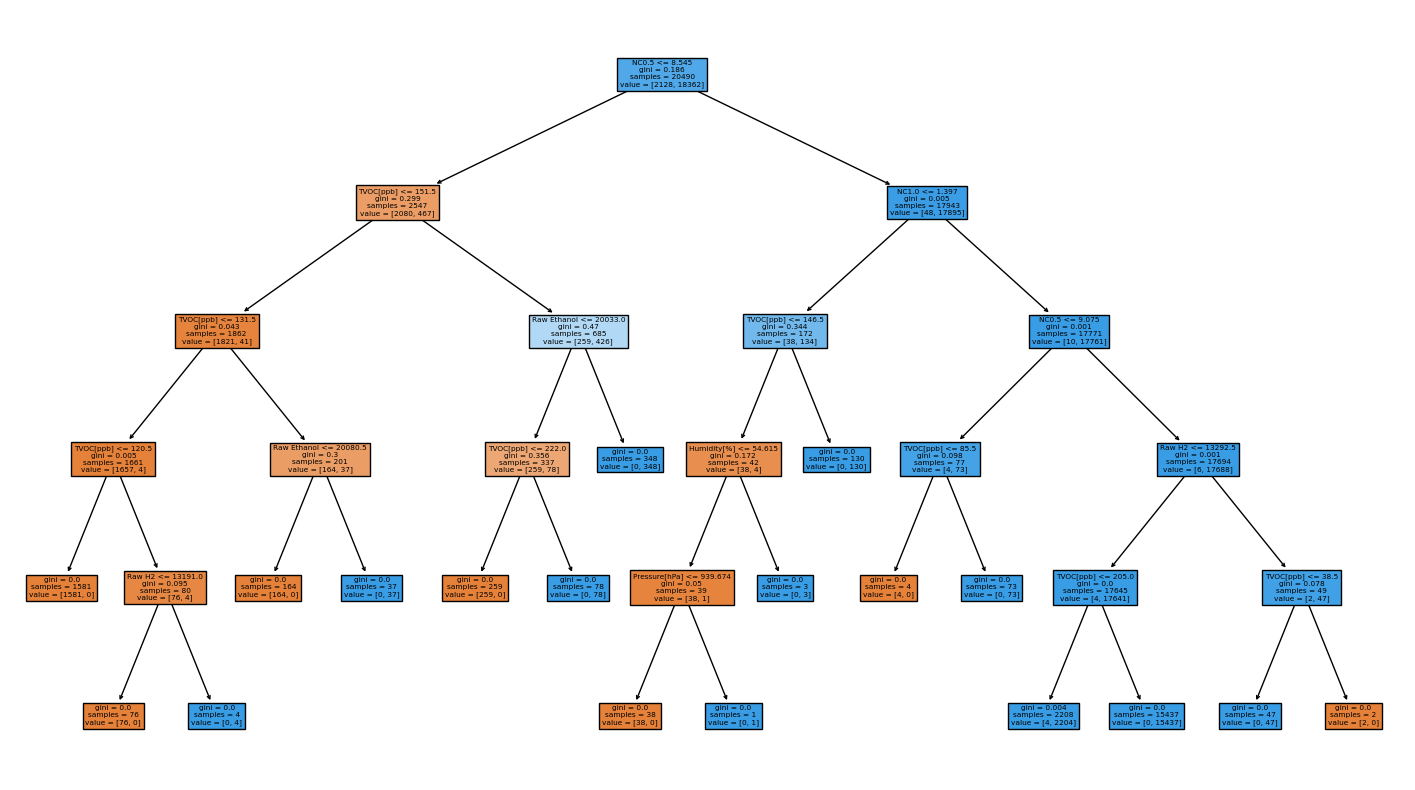

In [31]:
fig = plt.figure(figsize=(18,10))
_ = tree.plot_tree(clf,feature_names=Xn_train.columns,filled=True)
plt.savefig("decision_tree_new.png", bbox_inches='tight')

In [32]:
yn_pred=clf.predict(Xn_test)
print(classification_report(y_true=yn_test,y_pred=yn_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       512
           1       1.00      1.00      1.00      4611

    accuracy                           1.00      5123
   macro avg       1.00      1.00      1.00      5123
weighted avg       1.00      1.00      1.00      5123



Podemos ver que la precisión retornada es de 1 tanto para cuando suena la alarma como para cuando no suena. Es decir, el modelo es capaz de predecir con precisión del 100% si la alarma va a sonar o no. Podemos ver también que el f1-score es de 1 para la activacion de la alarma, es decir que no solo tiene buena precisión, sino tambien buena sensibilidad. Para la no activación de alarma tiene un f1-score de 0.99, lo cual es igualmente destacable. 

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3594
           1       1.00      1.00      1.00      8932

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526



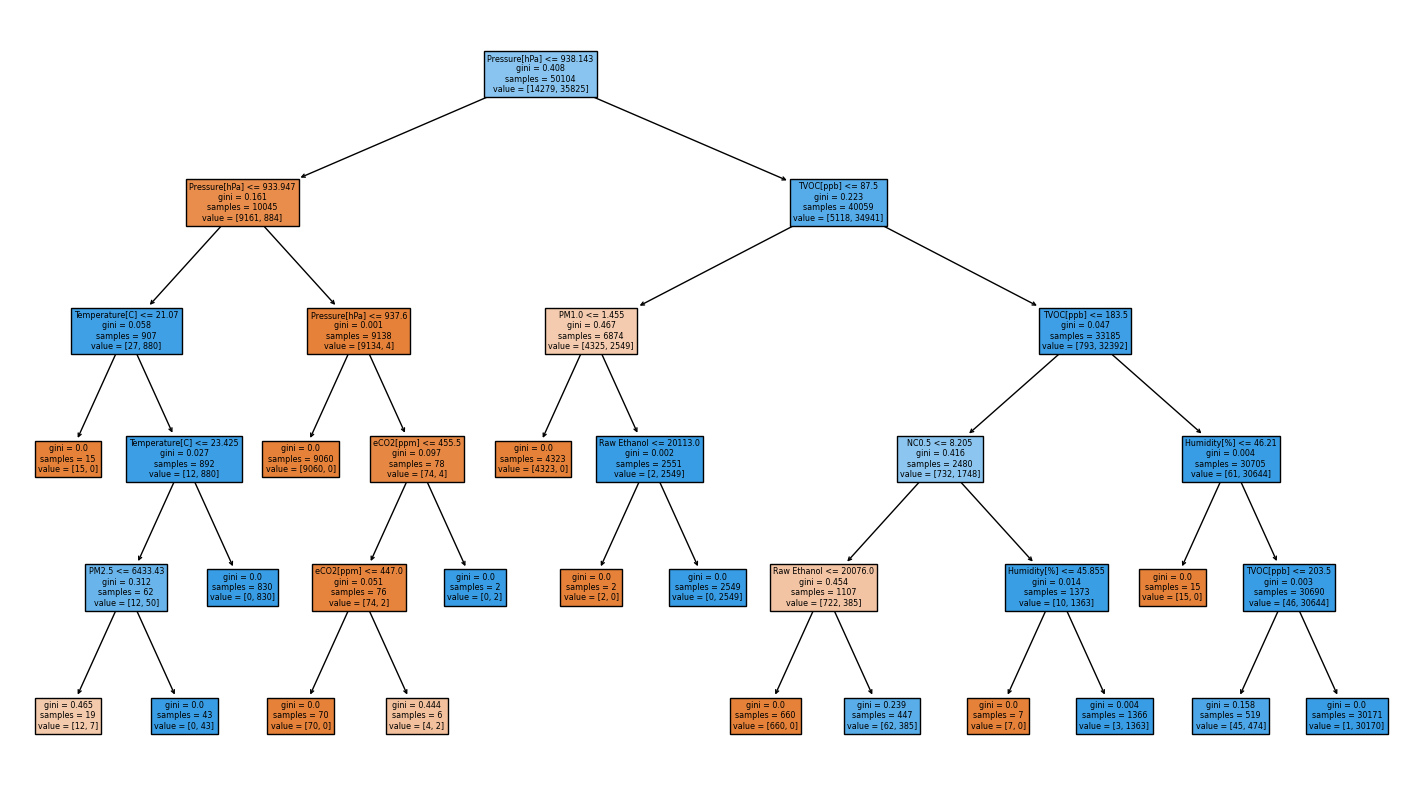

In [33]:
#Para los datos sin filtrar:


clf = DecisionTreeClassifier(random_state=1234,criterion='gini',max_depth=5)
model = clf.fit(X_train, y_train)

fig = plt.figure(figsize=(18,10))
_ = tree.plot_tree(clf,feature_names=X_train.columns,filled=True)
plt.savefig("decision_tree_new.png", bbox_inches='tight')

y_pred=clf.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_pred))

Nuevamente, con los datos sin filtrar el modelo no funciona bien. Con los datos filtrados el modelo funciona excelente.

### Bosques de decisión

In [34]:
#FILTRADO
clf = RandomForestClassifier(max_depth=6, random_state=42, n_estimators=30,criterion='gini')
clf.fit(Xn_train, yn_train)
yn_pred= clf.predict(Xn_test)
print(classification_report(y_pred=yn_pred, y_true= yn_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       512
           1       1.00      1.00      1.00      4611

    accuracy                           1.00      5123
   macro avg       1.00      1.00      1.00      5123
weighted avg       1.00      1.00      1.00      5123



Text(0.5, 0, 'Random Forest Feature Importance')

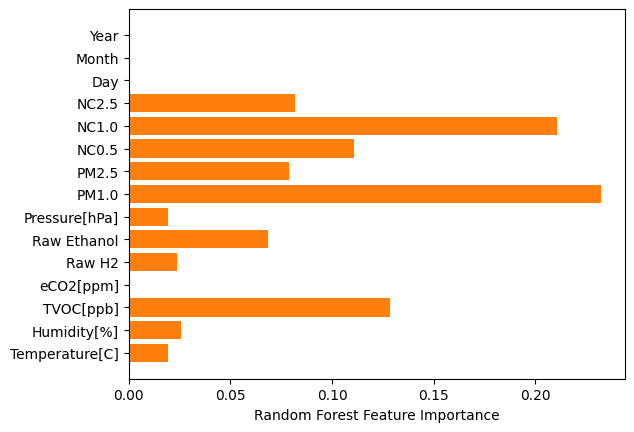

In [35]:
plt.barh(Xn_train.columns, clf.feature_importances_)
sorted_idx = clf.feature_importances_.argsort()
plt.barh(Xn_train.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

En este caso usé los datos completos y no solo las columnas indicadas por el feature selection. Veo que el feature selection de los datos filtrados me había dicho que NC1.0 no era relevante, sin embargo junto con PM1.0 son las mas importantes. (no sé por qué no me los ordena bien en orden decreciente).

In [36]:
#SIN FILTRAR
#modelo = RandomForestClassifier(random_state=42)
#modelo.fit(X_train, y_train)
# Obtenemos las predicciones del modelo con X_test
#preds = modelo.predict(X_test) 
#preds
clf = RandomForestClassifier(max_depth=6, random_state=42, n_estimators=30,criterion='gini')
clf.fit(X_train, y_train)
y_pred= clf.predict(X_test)
print(classification_report(y_pred=y_pred, y_true= y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3594
           1       1.00      1.00      1.00      8932

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526



Vemos que no hay falsos positivos ni falsos negativos, todo se predijo correctamente

### SVC

In [37]:
#FILTRADO

svm_model = SVC(kernel='linear')

svm_model.fit(Xn_train, yn_train)

yn_pred = svm_model.predict(Xn_test)

accuracy = accuracy_score(yn_test, yn_pred)
recall = recall_score(yn_test, yn_pred)
f1 = f1_score(yn_test, yn_pred)
confusion = confusion_matrix(yn_test, yn_pred)

print("Precisión del modelo SVM:", accuracy)
print("Recall:", recall)
print("Puntuación F1:", f1)
print("Matriz de confusión:")
print(confusion)

Precisión del modelo SVM: 1.0
Recall: 1.0
Puntuación F1: 1.0
Matriz de confusión:
[[ 512    0]
 [   0 4611]]


In [38]:
#SIN FILTRAR
svm_model = SVC(kernel='linear')

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("Precisión del modelo SVM:", accuracy)
print("Recall:", recall)
print("Puntuación F1:", f1)
print("Matriz de confusión:")
print(confusion)

: 

: 

### HDBSCAN
Se probará con este modelo de aprendizaje no supervisado, ya que es bastante robusto con datos que contienen valores atípicos como este caso. La mayoría de estos modelos no funcionan bien con variables discretas como es el caso de 'Fire Alarm', así que vamos a explorar otras opciones también.

Primero vamos a normalizar los datos

#### Normalización de datos

In [ ]:
from sklearn.preprocessing import StandardScaler
columnas_interes = df_smoke.columns.drop('Fire Alarm')
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_smoke[columnas_interes])
df_scaled = pd.DataFrame(df_scaled, columns=columnas_interes)
df_scaled['Fire Alarm'] = df_smoke['Fire Alarm']

No filtro los outliers porque este modelo teóricamente es robusto ante ellos.

In [ ]:
#no hay necesidad de esto porque el aprendizaje no supervisado no necesita variable target.
X_2 = df_scaled.drop("Fire Alarm", axis=1) 
y_2 = df_scaled['Fire Alarm'] 

In [ ]:
#no hay necesidad de esto porque el aprendizaje no supervisado no necesita variable target.
Xn_train, Xn_test, yn_train, yn_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

In [ ]:
!pip install hdbscan


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
from mpl_toolkits import mplot3d
from hdbscan import HDBSCAN

#crea una instancia del modelo HDBSCAN
hdbscan = HDBSCAN(min_cluster_size=20,
                 min_samples=10)

#aj el modelo a los datos de entrenamiento
preds=hdbscan.fit_predict(df_scaled)

# Obtener las etiquetas de cluster asignadas a cada muestra
cluster_labels = hdbscan_model.labels_

# Obtener el número de clusters encontrados (-1 representa los puntos de ruido/outliers)
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

# Imprimir el número de clusters encontrados
print("Número de clusters:", num_clusters)

# Realizar predicciones en los datos de prueba
y_pred = hdbscan_model.predict(Xn_test)

# Imprimir el rendimiento del modelo
print("Rendimiento del modelo:")
print(classification_report(yn_test, y_pred))

: 

: 

Efectivamente conviene filtrar los datos y eliminar los outliers, ya que todos los modelos de ML aplicados funcionan perfecto con los datos limpios pero cuando se usan los datos completos empeoran su performance.
Se podria intentar normalizar los datos y ver si esto cambia algo, quizas disminuyendo la cantidad de datos a eliminar como outliers.
Se podría hacer un analisis usando serie de tiempo también.
Se podría hacer un tunning fino de parámetros en los modelos de ML para ver si esto hace que los resultados con los datos sin filtrar mejoren.